In [ ]:
!pip install wordcloud
!pip install nltk
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet') 

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, classification_report
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer


#import dataset
df = pd.read_csv('DisneylandReviews.csv', encoding='ISO-8859-1')


#conver Ratings to Sentiment Labels

def label_sentiment(rating):
    if rating <= 2:
        return 'negative'
    if rating == 3:
        return 'neutral'
    else:
        return 'positive'

df['Sentiment'] = df['Rating'].apply(label_sentiment)

#first 5 rows of dataframe
print("First 5 rows of df: ")
print(df.head(10))

First 5 rows of df: 
   Review_ID  Rating Year_Month     Reviewer_Location  \
0  670772142       4     2019-4             Australia   
1  670682799       4     2019-5           Philippines   
2  670623270       4     2019-4  United Arab Emirates   
3  670607911       4     2019-4             Australia   
4  670607296       4     2019-4        United Kingdom   
5  670591897       3     2019-4             Singapore   
6  670585330       5     2019-4                 India   
7  670574142       3     2019-3              Malaysia   
8  670571027       2     2019-4             Australia   
9  670570869       5     2019-3                 India   

                                         Review_Text               Branch  \
0  If you've ever been to Disneyland anywhere you...  Disneyland_HongKong   
1  Its been a while since d last time we visit HK...  Disneyland_HongKong   
2  Thanks God it wasn   t too hot or too humid wh...  Disneyland_HongKong   
3  HK Disneyland is a great compact park. U

# Preprocess Step
this step takes a bit to run and give an output. there are 42,000 total reviews in the dataset, will try to optimize later.
takes about (3-5 mins i think).

In [6]:
#Preproccess test

def preprocess(text):
    print("1")
    # print(f"Processing: {text[:30]}...")  # Print first 30 characters of the text (for debugging)
    tokens = word_tokenize(text.lower())
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word.isalpha() and word not in stop_words]
    return ' '.join(tokens)

# Apply preprocessing to the review text
df['Cleaned_Text'] = df['Review_Text'].apply(preprocess)

# Display updated dataframe
print(df.head(5))
print("Done mf")

1
Processing: If you've ever been to Disneyl...
1
Processing: Its been a while since d last ...
1
Processing: Thanks God it wasn   t too hot...
1
Processing: HK Disneyland is a great compa...
1
Processing: the location is not in the cit...
1
Processing: Have been to Disney World, Dis...
1
Processing: Great place! Your day will go ...
1
Processing: Think of it as an intro to Dis...
1
Processing: Feel so let down with this pla...
1
Processing: I can go on talking about Disn...
1
Processing: Disneyland never cease to amaz...
1
Processing: We spent the day here with our...
1
Processing: We spend two days, the second ...
1
Processing: It was indeed the happiest pla...
1
Processing: This place is HUGE! Definately...
1
Processing: We brought tickets before we l...
1
Processing: Its huge , not enough to visit...
1
Processing: Around   60 per person and if ...
1
Processing: It   s Disneyland! It just doe...
1
Processing: There is nothing more to say e...
1
Processing: We bought a 2 day tourist 

# Sentiment Classifier
step 4 below is testing my own custom reviews to see if the model can identify

tried to balance the data with undersampler (step 1), but still have to many positive reviews. Will research this some more.


In [7]:
#3 Training Sentiment Classifier
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split


#To many positive reviews over negatives caused my model to not have enough negative data, so had to balance with RandomUnderSampler
#but even then not enough for a negative prediction. 

# Step 1: Balance the dataset using RandomUnderSampler
undersampler = RandomUnderSampler(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = undersampler.fit_resample(df[['Cleaned_Text']], df['Sentiment'])  # Use double brackets to create a DataFrame

# Step 2: Split the balanced data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Step 3: Train the sentiment classifier using the resampled (balanced) dataset
model = make_pipeline(TfidfVectorizer(), MultinomialNB())
model.fit(X_train['Cleaned_Text'], y_train)  # Fit on the cleaned text column

# Step 4: Predict sentiment on custom test reviews
test_reviews = ["The park was super cool!", "I didn't enjoy the rides, Best time ever!", 
                "It was okay, nothing special.", "The park was awesome."]
predictions = model.predict(test_reviews)
print("Predicted Sentiment on test reviews: ", predictions)

# Step 5: Evaluate the model on the test set
test_predictions = model.predict(X_test['Cleaned_Text'])  # Use cleaned text for predictions
print(classification_report(y_test, test_predictions))

# Step 6: Display the class distribution in the original dataset
print(df['Sentiment'].value_counts())



Predicted Sentiment on test reviews:  ['positive' 'positive' 'neutral' 'positive']
              precision    recall  f1-score   support

    negative       0.67      0.73      0.70       733
     neutral       0.52      0.54      0.53       712
    positive       0.81      0.71      0.75       731

    accuracy                           0.66      2176
   macro avg       0.67      0.66      0.66      2176
weighted avg       0.67      0.66      0.66      2176

Sentiment
positive    33921
neutral      5109
negative     3626
Name: count, dtype: int64


# Topic Modeling LDA

Ensures results can be reproduced.
The model learns the distribution of topics over the documents and the distribution of words over the topics from the input data X (the bag-of-words matrix).


In [8]:
# 4. Topic Modeling with LDA
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
X = vectorizer.fit_transform(df['Cleaned_Text'])

lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(X)


LatentDirichletAllocation(n_components=5, random_state=42)

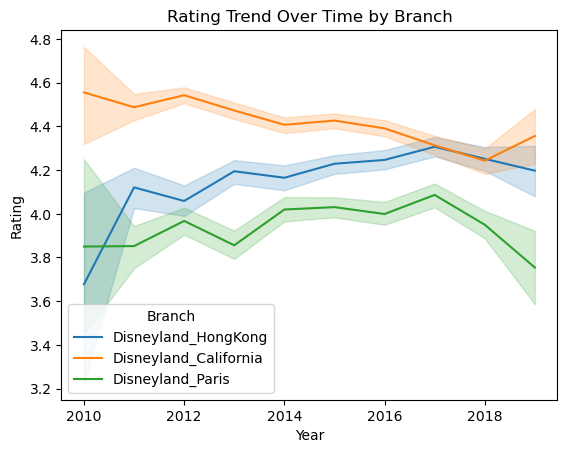

In [9]:
#5
#ratings over time

# Ensure 'Year_Month' is treated as string
df['Year_Month'] = df['Year_Month'].astype(str)

# Remove non-date entries from 'Year_Month'
df = df[df['Year_Month'].str.match(r'^\d{4}-\d+$')].copy()  # Use .copy() to avoid warning

# Convert 'Year_Month' to datetime for better handling
df['Year_Month'] = pd.to_datetime(df['Year_Month'].str.replace('-', '-01-'), format='%Y-%m-%d', errors='coerce')

# Drop any rows that could not be converted (NaT values)
df = df.dropna(subset=['Year_Month'])

# Extract year for plotting
df['Year'] = df['Year_Month'].dt.year

# ratings over time
sns.lineplot(x='Year', y='Rating', hue='Branch', data=df)
plt.title("Rating Trend Over Time by Branch")
plt.show()


# Multiclass prediction

once this step is finished the model will be able to automatically classify new reviews into specified rating categories based on the learned patterns in the text. 

In [11]:
#6
#train multiclass model for rating prediction

# rating_model = make_pipeline(Tfidvectorizer(), MultinomiaNB())
# rating_model.fit(df['Cleaned_Tet'], df['Rating']